In [2]:
from Util import *
from bdd100k_loader import *
from matplotlib import pyplot as plt
%matplotlib inline
import random
from livelossplot.keras_plot import PlotLossesKeras

import keras
from keras.layers import Lambda, Input, Conv2D, MaxPooling2D
from keras.models import Model
from keras.backend import tf
from keras.callbacks import ModelCheckpoint

loader = BDD100K_Loader(True)
loader_val = BDD100K_Loader(False)
color_map = generate_color_from_categories(loader.category_dict, scale=True)
rie = loader.reverse_index_encoding

{'traffic light': 186117, 'traffic sign': 239686, 'car': 713211, 'person': 91349, 'bus': 11672, 'truck': 29971, 'rider': 4517, 'bike': 7210, 'motor': 3002, 'train': 136}
{'traffic light': 0, 'traffic sign': 1, 'car': 2, 'person': 3, 'bus': 4, 'truck': 5, 'rider': 6, 'bike': 7, 'motor': 8, 'train': 9}
{'traffic sign': 34908, 'traffic light': 26885, 'car': 102506, 'rider': 649, 'motor': 452, 'person': 13262, 'bus': 1597, 'truck': 4245, 'bike': 1007, 'train': 15}
{'traffic sign': 0, 'traffic light': 1, 'car': 2, 'rider': 3, 'motor': 4, 'person': 5, 'bus': 6, 'truck': 7, 'bike': 8, 'train': 9}


In [3]:
inp = Input(shape=(None, None, 3))
resized = Lambda(lambda image: tf.image.resize_images(image, (270, 480))/255.0)(inp)

conv = Conv2D(kernel_size = (3,3), filters = 32, activation=tf.nn.leaky_relu)(resized)
mp = MaxPooling2D(pool_size = (2,2))(conv)

conv = Conv2D(kernel_size = (3,3), filters = 64, activation=tf.nn.leaky_relu)(mp)
mp = MaxPooling2D(pool_size = (2,2))(conv)

conv = Conv2D(kernel_size = (3,3), filters = 128, activation=tf.nn.leaky_relu)(mp)
conv = Conv2D(kernel_size = (1,1), filters = 64, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (3,3), filters = 128, activation=tf.nn.leaky_relu)(conv)
mp = MaxPooling2D(pool_size = (2,2))(conv)

conv = Conv2D(kernel_size = (3,3), filters = 256, activation=tf.nn.leaky_relu)(mp)
conv = Conv2D(kernel_size = (1,1), filters = 512, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (3,3), filters = 256, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (1,1), filters = 512, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (3,3), filters = 256, activation=tf.nn.leaky_relu)(conv)
mp = MaxPooling2D(pool_size = (2,2))(conv)

conv = Conv2D(kernel_size = (3,3), filters = 512, activation=tf.nn.leaky_relu)(mp)
conv = Conv2D(kernel_size = (1,1), filters = 1024, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (3,3), filters = 512, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (1,1), filters = 1024, activation=tf.nn.leaky_relu)(conv)
conv = Conv2D(kernel_size = (3,3), filters = 14*5, activation=tf.nn.sigmoid)(conv)

model = Model(input=inp, output=conv)
model.summary()   

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 270, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 268, 478, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 134, 239, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 132, 237, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 66, 118, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 116, 128)      73856     
__________

/home/calper/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, loader, batch_size=4):
        self.loader = loader
        self.batch_size = batch_size
        self.batch_count = 3#(self.loader.size//batch_size)+1
        self.patch_area = [6, 19]
        self.patch_depth = 5
        
    def __len__(self):
        return self.batch_count
    
    def __getitem__(self, index):
        X = np.zeros([self.batch_size, 720, 1280, 3])
        Y = np.zeros([self.batch_size, 
                      self.patch_area[0], 
                      self.patch_area[1],
                      self.patch_depth*self.loader.encode_length])
        i = index*self.batch_size
        b = 0
        while b < self.batch_size:
            x, y = loader.gather(i, self.patch_area, self.patch_depth)
            if x is not None:
                X[b] = x
                Y[b] = y
                i += 1
                b += 1
            else:
                i = 0
        return X, Y
    
    def on_epoch_end(self):
        pass

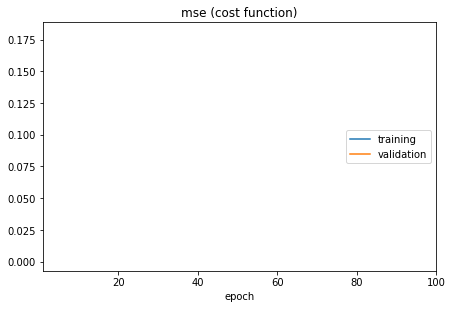


Epoch 00001: val_loss improved from -inf to 0.00159, saving model to weights/weights-improvement-01-0.00.hdf5


OSError: Unable to create file (unable to open file: name = 'weights/weights-improvement-01-0.00.hdf5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [5]:
checkpoint = ModelCheckpoint('weights/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='max')
training_generator = DataGenerator(loader)
validation_generator = DataGenerator(loader_val)
model.compile(optimizer='adam', loss='mse')

model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    verbose=True,
                    epochs=100,
                    callbacks=[PlotLossesKeras(), checkpoint])